In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from chnet.torchsummary import summary
from torchvision import transforms, utils
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [3]:
import chnet.utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools
from chnet.ch_loader import CahnHillDataset

In [4]:
warnings.filterwarnings('ignore')

In [5]:
@curry
def init_norm(nsamples, dim_x, dim_y, seed=354875, m_l=-0.15, m_r=0.15):
    np.random.seed(seed)
    means  = np.random.uniform(m_l, m_r, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.05, 0.3, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.98, 0.98, out=x_data)
    
    return x_data

## Loss Functions

In [6]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Data Generators

In [7]:
@curry
def data_generator_slices(nsamples=2, 
                   dim_x=64, 
                   init_steps=1, 
                   delta_sim_steps = 100,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   n_step = 4,
                   m_l=-0.15, 
                   m_r=0.15,
                   device = torch.device("cuda:0")):
    
    init_data = init_norm(nsamples, dim_x, dim_x, seed=seed, m_l=m_l, m_r=m_r)   

    x_list = []
    y_list = []
    
    x_data = ch.ch_run_torch(init_data, 
                             dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, 
                             device=device)    
    

    for _ in range(n_step):
        x_list.append(x_data[None])
        x_data = ch.ch_run_torch(x_data, 
                                 dt=dt, gamma=gamma, 
                                 dx=dx, sim_step=delta_sim_steps, 
                                 device=device)
        y_list.append(x_data[None])
    
    x_data = np.moveaxis(np.concatenate(x_list, axis=0), 0, 1)
    y_data = np.moveaxis(np.concatenate(y_list, axis=0), 0, 1)
    
    return x_data, y_data

# Set Device

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
%%time
x_data, y_data = data_generator_slices(nsamples=2, dim_x=64, 
                                init_steps=1, 
                                delta_sim_steps = 800,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = 23846,
                                device = device)

CPU times: user 2.63 s, sys: 1.03 s, total: 3.66 s
Wall time: 7.56 s


# Model Training

### Training and Validation data generation

In [13]:
## Process Parameters
dim_x=96
init_steps=1
delta_sim_steps = 400
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 237452 #110364
seed_val = 986423
seed_prd = 284296


trn_size = 5
n_samples_trn = 1024*trn_size

n_step = 5

batch_size = 8

In [14]:
transformer_x = lambda x: x[:,None]
transformer_y = lambda x: x[:,None]

In [95]:
from chnet.lstm_unet import LSTM_Unet

ngf = 32
model = LSTM_Unet(input_nc=1, output_nc=1, ngf=ngf, temporal=n_step, tanh=True).double().to(device)


model.load_state_dict(torch.load("out/unet_convLSTM_ch32_step_400_nstep_5_3rdtry.pt"))
from chnet.lstm_unet import Unet_solo
unet = Unet_solo(input_nc=1, 
                  output_nc=1, 
                  ngf=32, 
                  k=1, 
                  tanh=True).double().to(device)

unet.load_state_dict(torch.load("out/unet_model_ch32_1_400_longrun.pt", map_location=device))
model.unet.load_state_dict(unet.unet.state_dict())
model.uout.load_state_dict(unet.uout.state_dict())
for param in model.unet.parameters():
    param.requires_grad=False
for param in model.uout.parameters():
    param.requires_grad=False

8648514


In [110]:
criterion = mse_loss(scale=10000)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


trn_losses = []
log_step = 512

n_params = 0
for params in model.parameters():
    n_params += np.prod(params.shape)
print(n_params)

for param in model.unet.parameters():
    param.requires_grad=True
for param in model.uout.parameters():
    param.requires_grad=True

8648514


In [ ]:
model.train()
num_epochs = 10
for seed_trn in [1783*17, 8574*311, 2364*413, 871523*117, 8961*819, 98712*23, 14112*29, 15439*31, 92361*37]:
    x_trn, y_trn = data_generator_slices(nsamples=1*1024,
                                         dim_x=dim_x, 
                                         init_steps=init_steps, 
                                         delta_sim_steps = delta_sim_steps,
                                         dx=dx, 
                                         dt=dt,
                                         n_step=n_step,
                                         gamma=gamma, 
                                         seed=seed_trn,
                                         device=device)

    trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
    trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # Loss and optimizer
    for epoch in range(num_epochs):    
                    
        for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):       
            model.train()

            x = item_trn['x'].to(device)
            y_t = item_trn['y'].to(device)

            # Forward pass
            y_p, y_p1 = model(x)
            # loss = criterion(y_t, y_p)
            loss = criterion(y_t, y_p)*10 + criterion(y_t, y_p1)
    #         y_p, y_p1 = model(x[:,0])
    #         loss = criterion(y_t[:,-1], y_p) + criterion(y_t, y_p1)


            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            trn_losses.append(np.sqrt(loss.item()))

            if (i) % log_step == 0:                 
                print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}'.format(epoch+1, 
                                                                                    num_epochs, 
                                                                                    i+1, 
                                                                                    len(trn_loader), 
                                                                                    np.mean(trn_losses[-log_step:])))
            

        torch.save(model.state_dict(), "out/unet_convLSTM_ch{}_step_{}_nstep_{}_swapped.pt".format(ngf, delta_sim_steps, n_step)) 

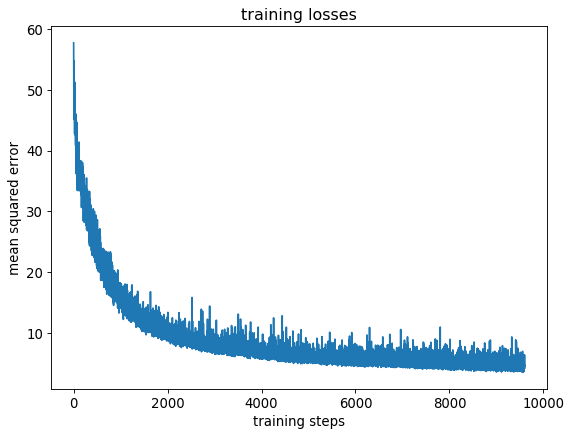

In [91]:
plt.plot(trn_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
plt.show()

In [35]:
model.eval()
x_val, y_val = data_generator_slices(nsamples=32, 
                              dim_x=96, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx = dx, 
                              dt = dt,
                              gamma=gamma, 
                              seed =174753,
                              n_step=n_step,
                              device = device)

prd_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
err = []
for ix, item_prd in enumerate(prd_dataset):
    x1 = item_prd['x'][None].to(device)
    y1 = item_prd['y'][None].to(device)
    y2, y2_u = model(x1)
    err.append(np.sqrt(mse_loss(y1.detach().cpu(), y2.detach().cpu())))
    
print("Mean Error on Validation Set: {:1.4f}".format(np.mean(err)))

Mean Error on Validation Set: 0.0489


In [103]:
model.eval()
nsamples=2
x_val, y_val = data_generator_slices(nsamples=nsamples, 
                              dim_x=96, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx = dx, 
                              dt = dt,
                              gamma=gamma, 
                              seed =174753,
                              n_step=n_step,
                              device = device)



val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
val_loader = DataLoader(val_dataset, batch_size=nsamples, shuffle=True, num_workers=1)

total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)

ix = 0

item_prd = next(iter(val_loader))
x1 = item_prd['x'].to(device)
y1 = item_prd['y'].to(device)
y2, y2_u = model.predict(x1[:,0])

print(rmse_loss(y1[:,0], y2_u[:,0]))

No. of validation steps: 1
tensor(0.0333, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


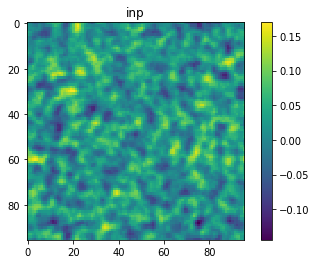

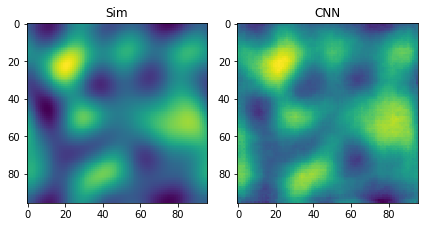

In [104]:
im_x1 = x1[ix][0].detach().cpu().numpy()

i = 0
im_y1 = y1[ix][i].detach().cpu().numpy()
im_y2 = y2_u[ix][i].detach().cpu().numpy()

utils.draw_im(im_x1[0], "inp")
utils.draw_by_side(im_y1[0], im_y2[0], title_left="Sim", title_right="CNN")